1. Importing Required Libraries

In [2]:
!pip install wordcloud


In [3]:
# Import essential libraries
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations and arrays
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns  # Statistical data visualization
%matplotlib inline 
# Import additional utilities
import re  # Regular expressions for text processing
import random  # Random operations

# Handling imbalanced datasets
from imblearn.over_sampling import RandomOverSampler  # Oversampling to balance class distribution

# Sparse matrix operations
from scipy.sparse import hstack  # Combines sparse matrices horizontally

# Word cloud visualization
from wordcloud import WordCloud  # Generates word cloud images for text analysis

# Natural Language Processing (NLP) tools
import nltk  # NLP toolkit
from nltk.tokenize import word_tokenize  # Tokenizes text into words
from nltk.stem import PorterStemmer  # Reduces words to their root form (stemming)

# Feature extraction for text data
from sklearn.feature_extraction.text import TfidfVectorizer  # Converts text data into numerical features

# Train-test split and hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV  # Splits data and optimizes model parameters

# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder  # Converts categorical labels into numerical values

# Machine learning models
from sklearn.linear_model import LogisticRegression  # Logistic Regression classifier
from sklearn.tree import DecisionTreeClassifier  # Decision Tree classifier


# Performance evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Measures model performance

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")  # Ignores warnings to keep output clean


2. Reading and Understanding the Data

In [5]:
df = pd.read_csv('Combined Data.csv', index_col=0)
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [6]:
df.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [8]:
#Looking at target variable
df.status.value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [9]:
# Convert all entries in 'statement' to strings
df["statement"] = df["statement"].astype(str)

# Remove rows where 'statement' is empty or contains only whitespace
df = df[df["statement"].str.strip() != ""]

# Verify the dataset after cleaning
print("\nDataset after cleaning:")
print(df.head())


Dataset after cleaning:
                                           statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety


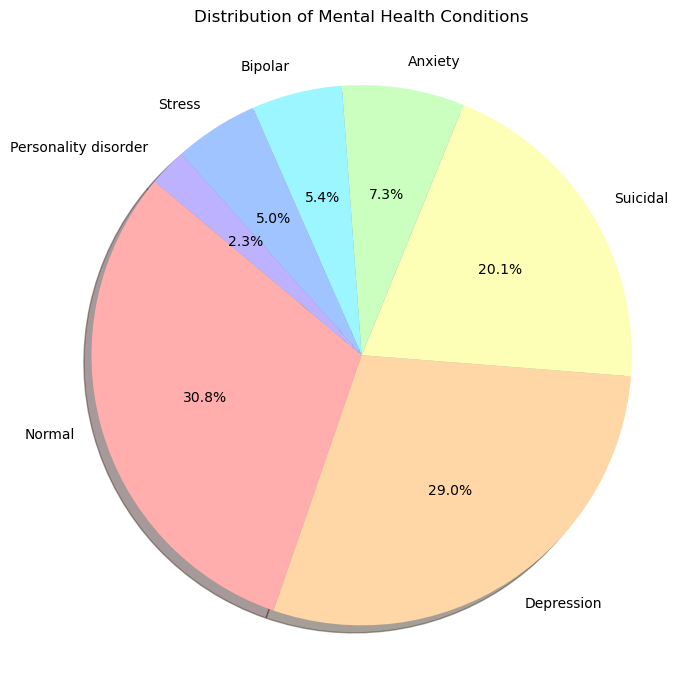

In [10]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#FFADAD', '#FFD6A5', '#FDFFB6', '#CAFFBF', '#9BF6FF', '#A0C4FF', '#BDB2FF']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

The target variable in the dataset is unbalanced. This imbalance could affect the model's performance, so I need to address it later to ensure accurate and fair predictions.

Looking at raw texts

In [13]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: Alternatives to WebMD and Google I've had mild health anxiety for few years now and I always use WebMD and Google to search new symptoms when they come up. Have you guys encountered anything that's better?

Status: Bipolar
Statement: Not sure this is allowed — how to know if a loved one is suffering through an undiagnosed bipolar manic episode. Throwaway — I am worried he will read this, and will only make things worse. 

[Since December — he has hit all of the signs.](https://www.medicalnewstoday.com/articles/313571.php) 

Could also be asked this way — how did you know you had bipolar disorder.. and if it was from a severe manic episode, how did you get help and stop your manic behavior? I have a loved one going through what looks like it hits all the signs — and of course I could be wrong —but I’m not able to get through to them to get help, even at the risk of losing everything. I’m at a complete loss on what to do, if there’s even anything I can do. Than

Adding new features

In [15]:
import nltk
nltk.download('punkt')  # Download the Punkt tokenizer model

# Calculate the number of characters in each statement
df['num_of_characters'] = df['statement'].str.len()

# Calculate the number of sentences in each statement
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics for character and sentence counts
description = df[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joshe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


       num_of_characters  num_of_sentences
count       53043.000000      53043.000000
mean          574.784816          6.244179
std           844.707198         10.660720
min             2.000000          1.000000
25%            77.000000          1.000000
50%           313.000000          3.000000
75%           748.000000          8.000000
max         32759.000000       1260.000000


I have several lengthy messages, most of which express suicidal thoughts or signs of depression:

In [17]:
df[df['num_of_characters'] > 10000]

,statement,status,num_of_characters,num_of_sentences
7851,So introduction I guess.. my name is Michael a...,Depression,10679,136
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,1
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,139
10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,237
11537,"The title is not meant to discourage others, b...",Depression,12304,155
11581,I no longer know what else to do but write thi...,Depression,13530,140
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,96
11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,155
13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759,1260
18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,180


3. Text Preprocessing

3.1. Lowercasing

Convert all statements to lowercase to ensure uniformity.

In [21]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)  

df['statement']=df['original_statement'].str.lower()
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,"i'm restless and restless, it's been a month n..."


3.2. Removing URLs, handles, punctuation and special characters

In [23]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


3.3. Tokenization

In [25]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo..."


3.4. Stemming

In [27]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens,tokens_stemmed
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


3.5. Stop Words
While stop words are typically removed to reduce noise, in sentiment analysis for mental health, many stop words are actually crucial for understanding context and sentiment. Words like negations and those related to emotions (e.g., 'how', 'why', 'because') provide important insights. Removing these can decrease the accuracy of the analysis.

3.6. Word Clouds

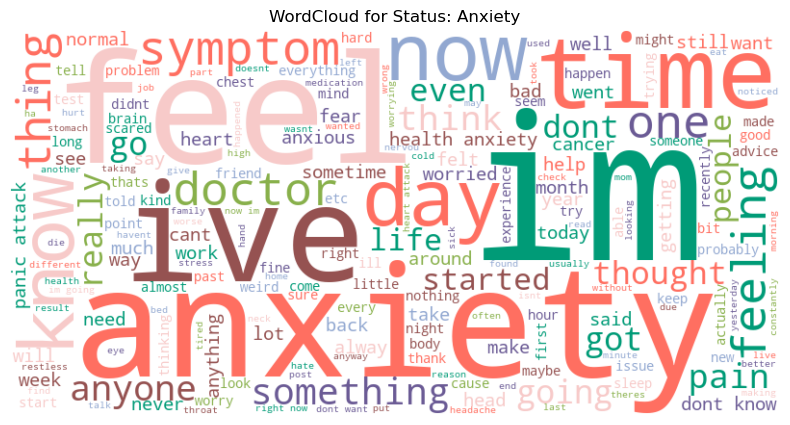

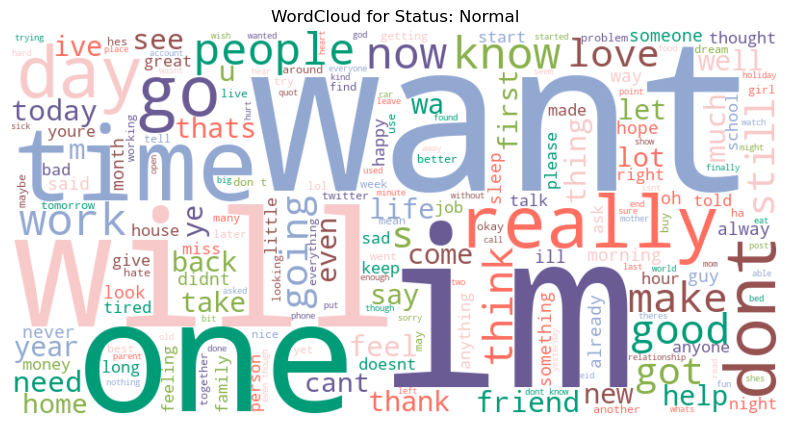

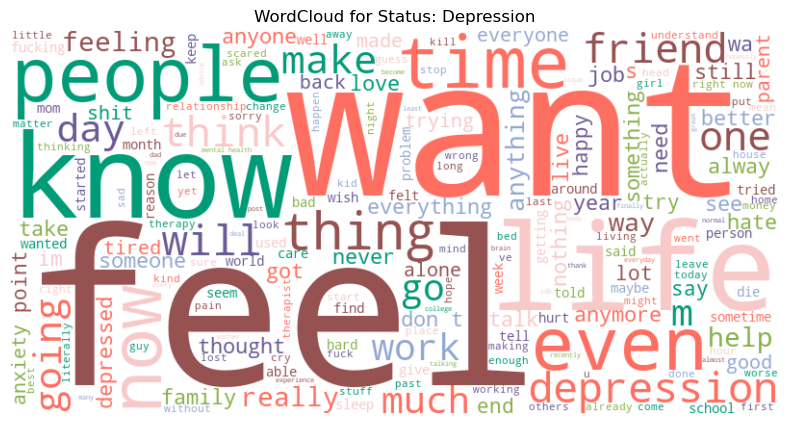

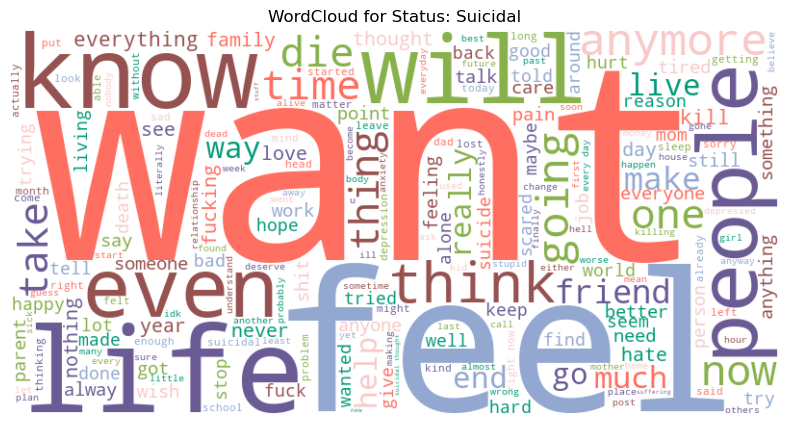

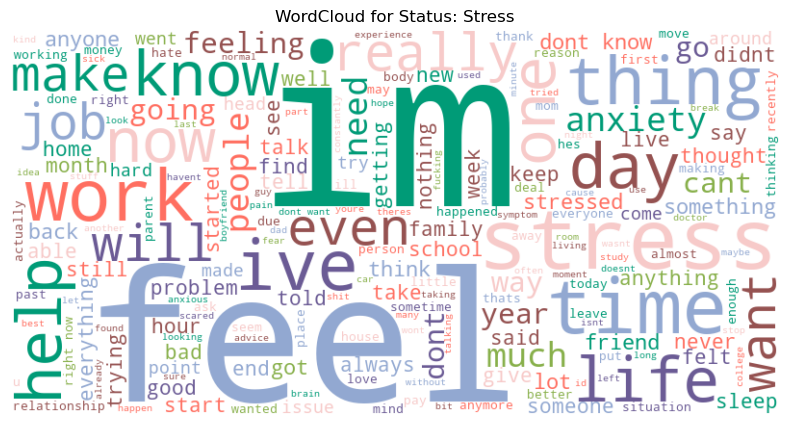

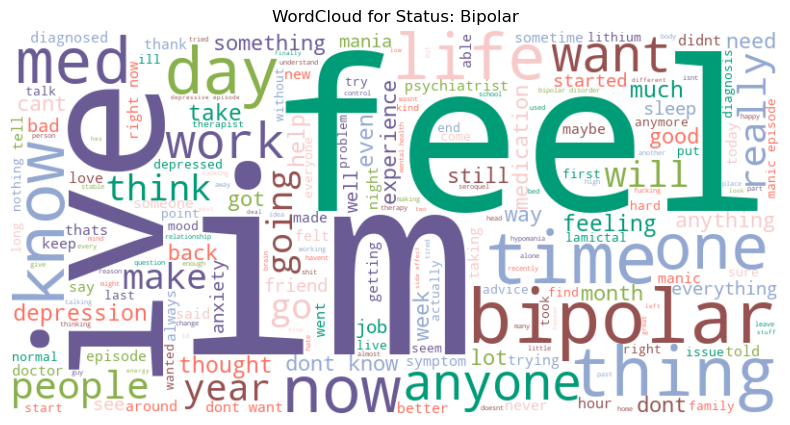

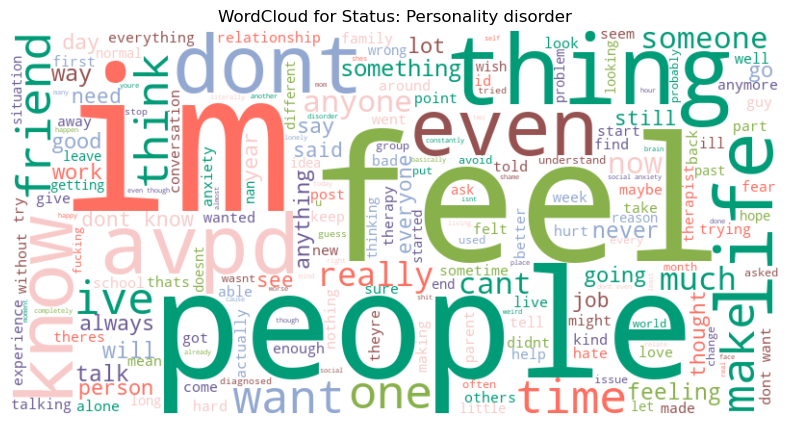

In [30]:
import random
from wordcloud import WordCloud
import matplotlib.pyplot as plt


colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1', '#955251', '#009B77']

# Define a color function to randomly assign colors from the palette
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Get unique categories in 'status'
statuses = df['status'].unique()

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()


There is a significant overlap in the language used for discussing depression and suicidal thoughts in our data. Many terms and phrases are used interchangeably or similarly for both conditions, which may complicate the distinction between them.

4. Data Preprocessing

4.1. Separate features and labels


In [34]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

4.2. Label encoding target variable

In [36]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

4.3. Split the data into training and testing sets

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

4.4. Convert text to features using TF-IDF vectoriser
Now, we will transform tokens (words) into numerical values that represent the importance of words in a document relative to a collection of documents. This helps highlight unique words in a document while downplaying common ones, making it easier for machine learning models to identify relevant patterns and make better predictions.

In [40]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [41]:
X_train_combined.shape

(42434, 50002)

4.5. Resampling


In [43]:
# Apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)
X_train_resampled.shape

(91693, 50002)

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from joblib import dump
import numpy as np
import re

# ------------------ STEP 0: Load Dataset ------------------
# Load the dataset
df = pd.read_csv('Combined Data.csv', index_col=0)

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# ------------------ STEP 1: Data Cleaning ------------------
# Ensure all entries in 'statement' are strings
df["statement"] = df["statement"].astype(str)

# Remove rows with empty strings or whitespace-only strings
df = df[df["statement"].str.strip() != ""]

# Clean text to remove invalid characters
def clean_text(text):
    text = re.sub(r"[^\x00-\x7F]+", "", text)  # Remove non-ASCII characters
    return text.strip()

df["statement"] = df["statement"].apply(clean_text)

# Drop rows where 'statement' is empty after cleaning
df = df[df["statement"] != ""]

# Verify the dataset after cleaning
print("\nDataset after cleaning:")
print(df.head())

# Extract text and label columns
X = df["statement"]  # Text data
y = df["status"]     # Labels (e.g., Anxiety, Depression, etc.)

# ------------------ STEP 2: Preprocessing ------------------
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed

# Debugging vectorization errors
try:
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
except ValueError as e:
    print(f"Error during vectorization: {e}")
    print("\nDebugging problematic rows...")
    for i, doc in enumerate(X_train):
        try:
            vectorizer.transform([doc])  # Test each document individually
        except ValueError:
            print(f"Problematic row index: {i}, Content: {doc}")
    raise

# Scale the vectorized data using StandardScaler
scaler = StandardScaler(with_mean=False)  # Use with_mean=False for sparse matrices
X_train_scaled = scaler.fit_transform(X_train_vectorized)
X_test_scaled = scaler.transform(X_test_vectorized)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Save the preprocessing tools
dump(vectorizer, "tfidf_vectorizer.pkl")
dump(scaler, "scaler.pkl")
print("✅ TfidfVectorizer and StandardScaler saved!")

First few rows of the dataset:
                                           statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety

Dataset after cleaning:
                                           statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety
✅ TfidfVectorizer and StandardScaler saved!


5. Model Traning and Evaluation

In [46]:
!pip install tqdm

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC  # Add LinearSVC
from sklearn.ensemble import RandomForestClassifier
from joblib import dump
from tqdm import tqdm  # For progress bar

# Define classifiers with reduced complexity for faster training
classifiers = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42),  # Reduced complexity
    'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=8, random_state=42, n_jobs=-1),  # Fewer trees, parallel processing
    'Linear SVC': LinearSVC(C=1.0, penalty='l2', dual=False, max_iter=1000, random_state=42)  # Replace Logistic Regression
}

# Train and save models with a progress bar
for name, clf in tqdm(classifiers.items(), desc="Training Models", unit="model"):
    print(f"\n🔹 Training: {name}")
    
    # Train the model
    clf.fit(X_train_resampled, y_train_resampled)
    
    # Save the trained model to disk
    dump(clf, f"{name}_model.pkl")
    print(f"✅ {name} model saved!")

Training Models:   0%|          | 0/3 [00:00<?, ?model/s]


🔹 Training: Decision Tree


Training Models:  33%|███▎      | 1/3 [00:04<00:08,  4.00s/model]

✅ Decision Tree model saved!

🔹 Training: Random Forest


Training Models:  67%|██████▋   | 2/3 [00:05<00:02,  2.55s/model]

✅ Random Forest model saved!

🔹 Training: Linear SVC


Training Models: 100%|██████████| 3/3 [02:47<00:00, 55.74s/model]

✅ Linear SVC model saved!



 Evaluating: Decision Tree
 Accuracy: 0.5563


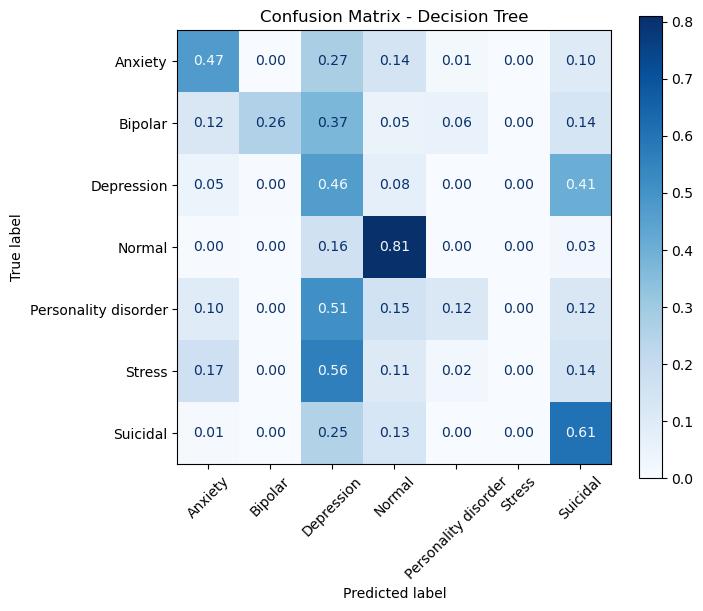


 Evaluating: Random Forest
 Accuracy: 0.6474


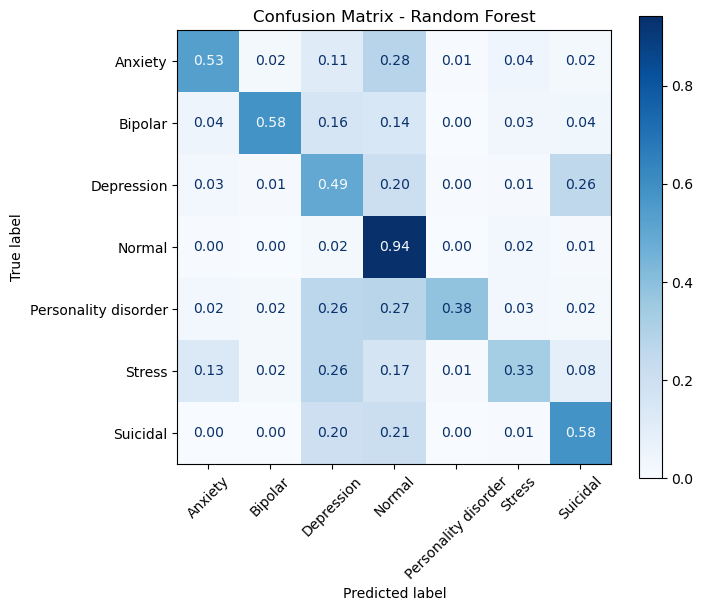


 Evaluating: Linear SVC
 Accuracy: 0.6527


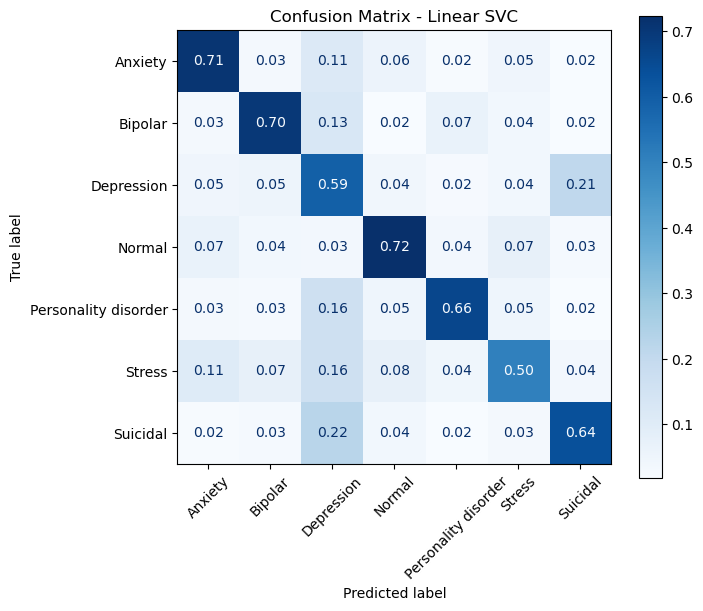

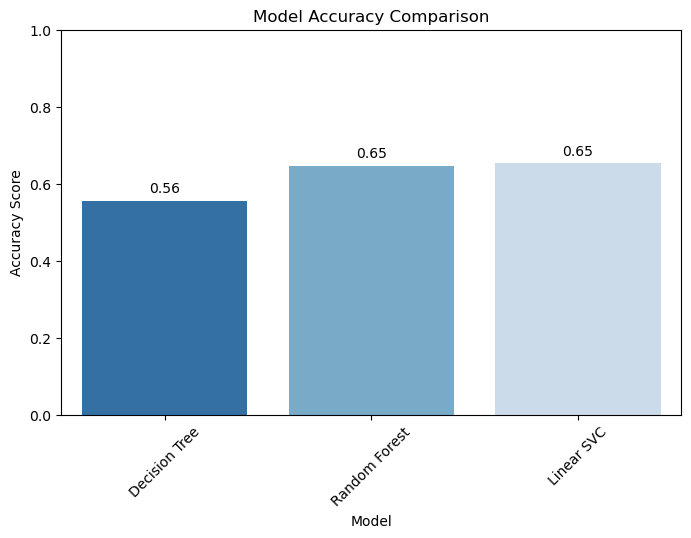


 Classification Report for Decision Tree:

                      precision  recall  f1-score    support
Anxiety                   0.494   0.471     0.482    779.000
Bipolar                   0.892   0.257     0.399    580.000
Depression                0.430   0.465     0.447   3100.000
Normal                    0.785   0.809     0.797   3327.000
Personality disorder      0.341   0.117     0.174    248.000
Stress                    0.000   0.000     0.000    557.000
Suicidal                  0.432   0.607     0.504   2018.000
accuracy                  0.556   0.556     0.556      0.556
macro avg                 0.482   0.389     0.401  10609.000
weighted avg              0.547   0.556     0.538  10609.000

 Classification Report for Random Forest:

                      precision  recall  f1-score    support
Anxiety                   0.672   0.531     0.594    779.000
Bipolar                   0.856   0.583     0.693    580.000
Depression                0.641   0.494     0.558   3100.0

In [49]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from joblib import load  # Import the load function
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dictionary to store results
accuracy_scores = {}
classification_reports = {}

for name in classifiers.keys():
    print(f"\n Evaluating: {name}")
    
    # Load the trained model
    clf = load(f"{name}_model.pkl")  # Load the saved model
    
    # Make predictions on the test set
    y_pred = clf.predict(X_test_scaled)  # Ensure X_test_scaled is used here
    
    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores[name] = accuracy  # Store accuracy
    
    print(f" Accuracy: {accuracy:.4f}")
    
    # Compute confusion matrix (normalized for better readability)
    conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')  # Normalize rows (per class)
    
    # Convert classification report to a DataFrame
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports[name] = pd.DataFrame(report).transpose()

    # --- Improved Confusion Matrix Visualization ---
    fig, ax = plt.subplots(figsize=(7, 6))
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Anxiety", "Bipolar", "Depression", "Normal", "Personality disorder", "Stress", "Suicidal"])
    disp.plot(cmap='Blues', values_format=".2f", ax=ax)  # Show percentages (2 decimal places)
    
    plt.title(f'Confusion Matrix - {name}')
    plt.xticks(rotation=45)  # Rotate labels for readability
    plt.show()

# --- Accuracy Score Bar Chart ---
plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()), palette='Blues_r')
plt.ylim(0, 1)  # Ensure full scale from 0 to 1
plt.xlabel("Model")
plt.ylabel("Accuracy Score")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)

# Add accuracy values on top of bars
for index, value in enumerate(accuracy_scores.values()):
    plt.text(index, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

plt.show()

# --- Display Classification Reports ---
for name, report_df in classification_reports.items():
    print(f"\n Classification Report for {name}:\n")
    print(report_df.round(3))

In [3]:
from joblib import load  # To load the saved models
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# ------------------ STEP 1: Load Models and Preprocessing Tools ------------------
# Load preprocessing tools
vectorizer = load("tfidf_vectorizer.pkl")
scaler = load("scaler.pkl")

# Load all pre-trained models
decision_tree_model = load("Decision Tree_model.pkl")
random_forest_model = load("Random Forest_model.pkl")
linear_svc_model = load("Linear SVC_model.pkl")

# Dictionary of models for easy selection
models = {
    "Decision Tree": decision_tree_model,
    "Random Forest": random_forest_model,
    "Linear SVC": linear_svc_model
}

# Categories for mapping predictions
categories = ["Anxiety", "Bipolar", "Depression", "Normal", "Personality disorder", "Stress", "Suicidal"]

# ------------------ STEP 2: Prediction Function with Model Selection ------------------
def predict_mental_health():
    """
    Function to allow users to input data and predict mental health using selected model.
    """
    while True:  # Loop to allow repeated predictions
        print("\n--- Mental Health Prediction Tool ---\n")
        
        # Step 1: Allow user to select a model
        print("Available models:")
        for i, model_name in enumerate(models.keys()):
            print(f"{i + 1}. {model_name}")
        
        try:
            model_choice = int(input("\nEnter the number of the model you want to use: "))
            selected_model_name = list(models.keys())[model_choice - 1]
            selected_model = models[selected_model_name]
            print(f"\nYou have selected: {selected_model_name}\n")
        except (ValueError, IndexError):
            print("Invalid choice. Defaulting to Random Forest.")
            selected_model_name = "Random Forest"
            selected_model = models["Random Forest"]
        
        # Step 2: Collect user input
        user_input = input("Please enter your text (e.g., symptoms or feelings): ")
        
        if user_input.strip() == "":
            print("Error: Please provide valid input.")
            continue  # Skip to the next iteration if input is invalid
        
        # Step 3: Preprocess the user input
        # Vectorize the text input
        user_input_vectorized = vectorizer.transform([user_input])
        
        # Scale the vectorized input
        user_input_scaled = scaler.transform(user_input_vectorized)
        
        # Step 4: Make predictions
        prediction = selected_model.predict(user_input_scaled)[0]  # Get the predicted class
        
        # Map the prediction to the corresponding mental health category
        if isinstance(prediction, int):  # If the prediction is an integer index
            predicted_category = categories[prediction]
        elif isinstance(prediction, str):  # If the prediction is a string label
            predicted_category = prediction
        else:
            print("Error: Unexpected prediction format.")
            continue  # Skip to the next iteration if prediction format is invalid
        
        # Step 5: Display the result
        print(f"\nPredicted Mental Health Category ({selected_model_name}): {predicted_category}\n")
        print("--- Thank you for using the Mental Health Prediction Tool ---\n")
        
        # Step 6: Ask the user if they want to use the tool again
        use_again = input("Would you like to make another prediction? (yes/no): ").strip().lower()
        if use_again not in ["yes", "y"]:
            print("Thank you for using the Mental Health Prediction Tool. Goodbye!")
            break  # Exit the loop if the user does not want to continue

# ------------------ STEP 3: Run the Prediction Function ------------------
# Run the prediction function
predict_mental_health()


--- Mental Health Prediction Tool ---

Available models:
1. Decision Tree
2. Random Forest
3. Linear SVC



Enter the number of the model you want to use:  3



You have selected: Linear SVC



Please enter your text (e.g., symptoms or feelings):  i feel sad



Predicted Mental Health Category (Linear SVC): Depression

--- Thank you for using the Mental Health Prediction Tool ---



Would you like to make another prediction? (yes/no):  y



--- Mental Health Prediction Tool ---

Available models:
1. Decision Tree
2. Random Forest
3. Linear SVC



Enter the number of the model you want to use:  4


Invalid choice. Defaulting to Random Forest.


Please enter your text (e.g., symptoms or feelings):  dead



Predicted Mental Health Category (Random Forest): Normal

--- Thank you for using the Mental Health Prediction Tool ---



Would you like to make another prediction? (yes/no):  n


Thank you for using the Mental Health Prediction Tool. Goodbye!
